In [536]:
import openml
import optuna
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

In [537]:
dataset = openml.datasets.get_dataset(42900)
X, y, categorical_indicator, attribute_names = dataset.get_data(
    dataset_format="dataframe", target=dataset.default_target_attribute
)

In [538]:
X.head()

,Age,BMI,Glucose,Insulin,HOMA,Leptin,Adiponectin,Resistin,MCP.1
0,48,23.500000,70,2.707,0.467409,8.8071,9.702400,7.99585,417.114
1,83,20.690495,92,3.115,0.706897,8.8438,5.429285,4.06405,468.786
2,82,23.124670,91,4.498,1.009651,17.9393,22.432040,9.27715,554.697
3,68,21.367521,77,3.226,0.612725,9.8827,7.169560,12.76600,928.220
4,86,21.111111,92,3.549,0.805386,6.6994,4.819240,10.57635,773.920


<AxesSubplot:>

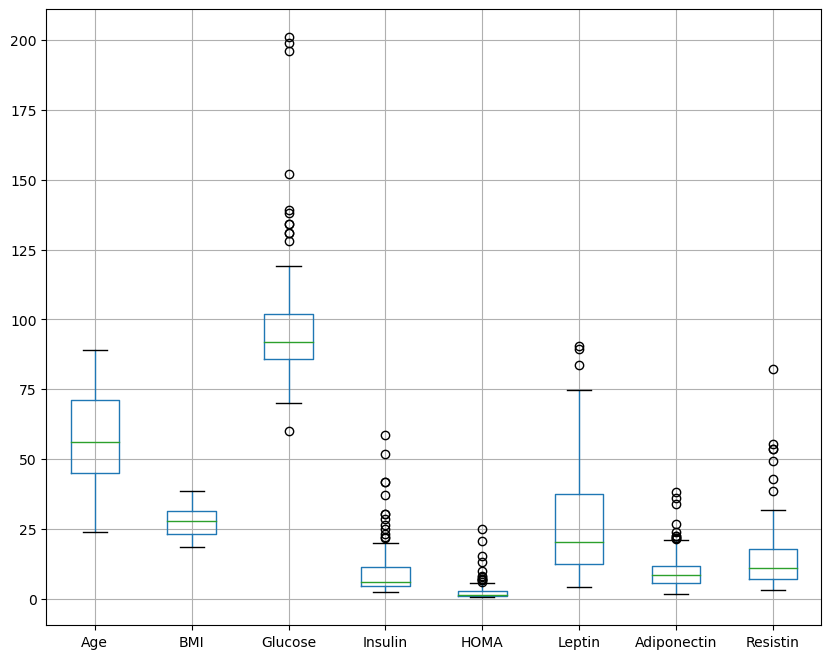

In [539]:
X[['Age', 'BMI', 'Glucose', 'Insulin', 'HOMA', 'Leptin', 'Adiponectin', 'Resistin']].boxplot(figsize=(10, 8))

<AxesSubplot:>

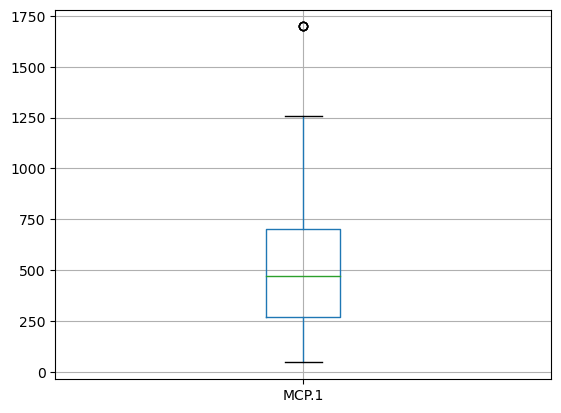

In [540]:
X[['MCP.1']].boxplot()

In [541]:
mask = np.array([False] * X.shape[0])
for i in X.columns:
    Q1 = np.percentile(X[i], 25, interpolation='midpoint')
    Q3 = np.percentile(X[i], 75, interpolation='midpoint')
    IQR = Q3 - Q1
    upper = Q3 + 1.5*IQR
    lower = Q3 - 1.5*IQR
    mask |= np.array(X[i] >= upper) | np.array(X[i] <= lower)
mask = mask == False

In [542]:
X = X[mask]
y = y[mask]

<AxesSubplot:>

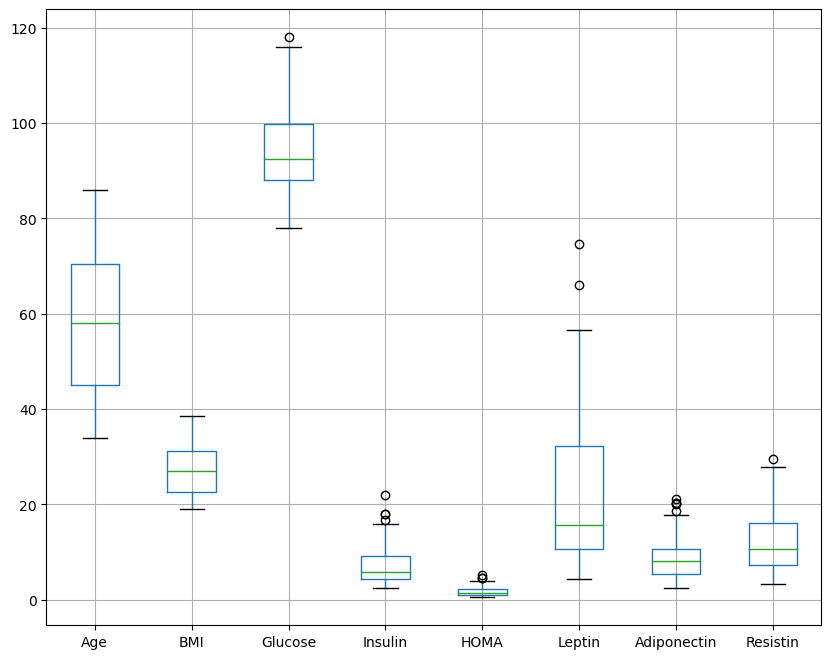

In [543]:
X[['Age', 'BMI', 'Glucose', 'Insulin', 'HOMA', 'Leptin', 'Adiponectin', 'Resistin']].boxplot(figsize=(10, 8))

<AxesSubplot:>

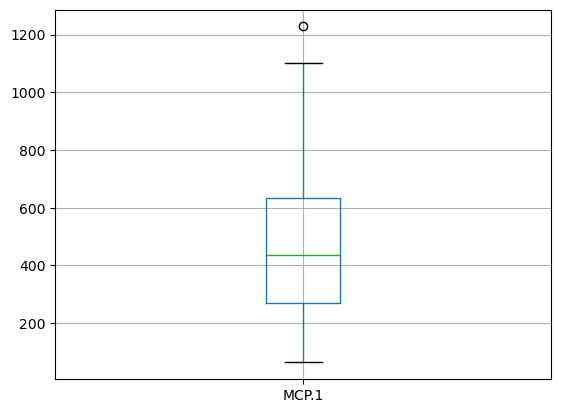

In [544]:
X[['MCP.1']].boxplot()

## Normalise

In [545]:
scaler = MinMaxScaler()
X_norm = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
X_norm.head()

,Age,BMI,Glucose,Insulin,HOMA,Leptin,Adiponectin,Resistin,MCP.1
0,0.942308,0.080111,0.350,0.034845,0.041765,0.064390,0.163941,0.029402,0.348000
1,1.000000,0.101741,0.350,0.056987,0.062439,0.033928,0.131304,0.277334,0.610075
2,0.288462,0.191391,0.350,0.040508,0.047053,0.035807,0.605339,0.267483,0.400928
3,0.807692,0.240014,1.000,0.206010,0.288689,0.000000,0.582418,0.069002,0.186450
4,0.750000,0.147451,0.475,0.046834,0.061633,0.002259,0.427665,0.113936,0.062909


In [546]:
train_x, test_x, train_y, test_y = train_test_split(X_norm, y, test_size=0.2, random_state=5)
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.3, random_state=2)

In [547]:
def objective(trial, v_x=val_x, v_y=val_y):
    algo_name = trial.suggest_categorical('classificator', ['kNN', 'SVC', 'Bayes', 'DecisionTree', 'RandomForest'])
    if algo_name == 'kNN':
        n_neighbors = trial.suggest_int('n_neigbors', 2, 10)
        weights = trial.suggest_categorical('weights', ['uniform', 'distance'])
        algorithm = trial.suggest_categorical('algorithm', ['auto', 'ball_tree', 'kd_tree', 'brute'])
        leaf_size = trial.suggest_int('leaf_size', 20, 40)
        p = trial.suggest_int('p', 1, 10)
        algo = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights, algorithm=algorithm, leaf_size=leaf_size, p=p, n_jobs=-1)
    elif algo_name == 'SVC':
        C = trial.suggest_float('C', 1e-5, 1e5, log=True)
        #kernel = trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed'])
        degree = trial.suggest_int('degree', 0, 5)
        gamma = trial.suggest_categorical('gamma', ['scale', 'auto'])
        algo = SVC(C=C, degree=degree, gamma=gamma)
    elif algo_name == 'Bayes':
        alpha = trial.suggest_float('alpha', 1e-5, 1e5, log=True)
        fit_prior = trial.suggest_categorical('fit_prior', [True,  False])
        algo = MultinomialNB(alpha=alpha, fit_prior=fit_prior)
    elif algo_name == 'DecisionTree':
        criterion = trial.suggest_categorical('criterion', ['gini', 'entropy', 'log_loss'])
        splitter = trial.suggest_categorical('splitter', ['best', 'random'])
        max_depth = trial.suggest_int('max_depth', 2, 50)
        min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
        min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 20)
        min_weight_fraction_leaf = trial.suggest_float('min_weight_fraction_leaf', 0.0, 0.5)
        random_state = trial.suggest_int('random_state', 0, 100)
        algo = DecisionTreeClassifier(criterion=criterion, 
                                      splitter=splitter,
                                      max_depth=max_depth, 
                                      min_samples_split=min_samples_split, 
                                      min_samples_leaf=min_samples_leaf, 
                                      min_weight_fraction_leaf=min_weight_fraction_leaf,
                                      random_state=random_state)
    elif algo_name == 'RandomForest':
        n_estimators = trial.suggest_int('n_estimators', 10, 200)
        criterion = trial.suggest_categorical('criterion', ['gini', 'entropy', 'log_loss'])
        max_depth = trial.suggest_int('max_depth', 2, 50)
        min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
        min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 20)
        min_weight_fraction_leaf = trial.suggest_float('min_weight_fraction_leaf', 0.0, 0.5)
        random_state = trial.suggest_int('random_state', 0, 100)
        algo = RandomForestClassifier(n_estimators=n_estimators,
                                      criterion=criterion,
                                      max_depth=max_depth,
                                      min_samples_split=min_samples_split,
                                      min_samples_leaf=min_samples_leaf,
                                      min_weight_fraction_leaf=min_weight_fraction_leaf,
                                      random_state=random_state)
    algo.fit(train_x, train_y)
    pred_y = algo.predict(v_x)
    score = f1_score(v_y, pred_y)
    return score

In [548]:
study = optuna.create_study(sampler=optuna.samplers.TPESampler(), pruner=optuna.pruners.HyperbandPruner(), direction='maximize')
study.optimize(objective, n_trials=100)

[I 2023-03-09 16:58:26,880] A new study created in memory with name: no-name-0fc53e78-f5ad-43e2-872b-bd3dc1f400a3
[I 2023-03-09 16:58:27,219] Trial 0 finished with value: 0.5714285714285714 and parameters: {'classificator': 'kNN', 'n_neigbors': 8, 'weights': 'distance', 'algorithm': 'ball_tree', 'leaf_size': 32, 'p': 2}. Best is trial 0 with value: 0.5714285714285714.
[I 2023-03-09 16:58:27,456] Trial 1 finished with value: 0.6086956521739131 and parameters: {'classificator': 'RandomForest', 'n_estimators': 150, 'criterion': 'gini', 'max_depth': 39, 'min_samples_split': 20, 'min_samples_leaf': 13, 'min_weight_fraction_leaf': 0.32592520781501344, 'random_state': 3}. Best is trial 1 with value: 0.6086956521739131.
[I 2023-03-09 16:58:27,559] Trial 2 finished with value: 0.7999999999999999 and parameters: {'classificator': 'Bayes', 'alpha': 5.168938099066525, 'fit_prior': False}. Best is trial 2 with value: 0.7999999999999999.
[I 2023-03-09 16:58:27,608] Trial 3 finished with value: 0.615

In [549]:
study.best_params

{'classificator': 'Bayes', 'alpha': 21.74240596668165, 'fit_prior': False}

In [550]:
study.best_value

0.8750000000000001

In [551]:
objective(study.best_trial, test_x, test_y)

0.7692307692307692

## Analysis

In [552]:
random_study = optuna.create_study(sampler=optuna.samplers.RandomSampler(), pruner=optuna.pruners.MedianPruner(), direction='maximize')
random_study.optimize(objective, n_trials=100)

[I 2023-03-09 16:58:31,003] A new study created in memory with name: no-name-1ecdd175-45b7-4aed-b53c-2f3f5ecb6a93
[I 2023-03-09 16:58:31,021] Trial 0 finished with value: 0.8750000000000001 and parameters: {'classificator': 'Bayes', 'alpha': 468.78878515269326, 'fit_prior': False}. Best is trial 0 with value: 0.8750000000000001.
[I 2023-03-09 16:58:31,146] Trial 1 finished with value: 0.6153846153846153 and parameters: {'classificator': 'kNN', 'n_neigbors': 3, 'weights': 'distance', 'algorithm': 'kd_tree', 'leaf_size': 34, 'p': 9}. Best is trial 0 with value: 0.8750000000000001.
[I 2023-03-09 16:58:31,155] Trial 2 finished with value: 0.6086956521739131 and parameters: {'classificator': 'SVC', 'C': 1.547720439882815e-05, 'degree': 5, 'gamma': 'scale'}. Best is trial 0 with value: 0.8750000000000001.
[I 2023-03-09 16:58:31,162] Trial 3 finished with value: 0.7777777777777778 and parameters: {'classificator': 'Bayes', 'alpha': 0.0005999996229587606, 'fit_prior': True}. Best is trial 0 wi

In [553]:
random_study.best_params

{'classificator': 'Bayes', 'alpha': 468.78878515269326, 'fit_prior': False}

In [554]:
random_study.best_value

0.8750000000000001

In [555]:
print(f'Random study score: {objective(random_study.best_trial, test_x, test_y)}\nTPE study score: {objective(study.best_trial, test_x, test_y)}')

Random study score: 0.8571428571428571
TPE study score: 0.7692307692307692


In [556]:
optuna.visualization.plot_optimization_history(study).show()

In [557]:
optuna.visualization.plot_optimization_history(random_study).show()

In [558]:
params = list(study.best_params)
params.remove('classificator')
optuna.visualization.plot_param_importances(study, params=params)

In [559]:
params = list(random_study.best_params)
params.remove('classificator')
optuna.visualization.plot_param_importances(random_study, params=params)